In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Step 2: Define function to load from a GeoTIFF file
def load_tif(image_path):
    with rasterio.open(image_path) as src:
        img = src.read(1)
        
    return img

In [3]:
def calc_mndwi(green_band_path, swir_band_path, year):
    """
    Calculate and visualize the Modified Normalized Difference Water Index (MNDWI).
    
    Parameters:
    - green_band_path: Path to the Green band (e.g., Band 3 for Landsat 8)
    - swir_band_path: Path to the SWIR band (e.g., Band 6 for Landsat 8)
    - year: Year for labeling the output visualization
    """
    # Step 1: Load Green and SWIR bands
    green = load_tif(green_band_path)
    swir = load_tif(swir_band_path)

    # Step 2: Calculate MNDWI
    mndwi = (green - swir) / (green + swir)

    # Step 3: Plot the MNDWI result
    plt.figure(figsize=(8, 6))
    plt.imshow(mndwi, cmap='Blues', vmin=-1, vmax=1)
    plt.colorbar(label="MNDWI")
    plt.title(f"Modified Normalized Difference Water Index (MNDWI) {year}")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    plt.show()

/var/folders/_t/trdgwqmj5vl_d8t1_8mx10d40000gn/T/ipykernel_12134/3844421466.py:15: RuntimeWarning: invalid value encountered in divide
  mndwi = (green - swir) / (green + swir)


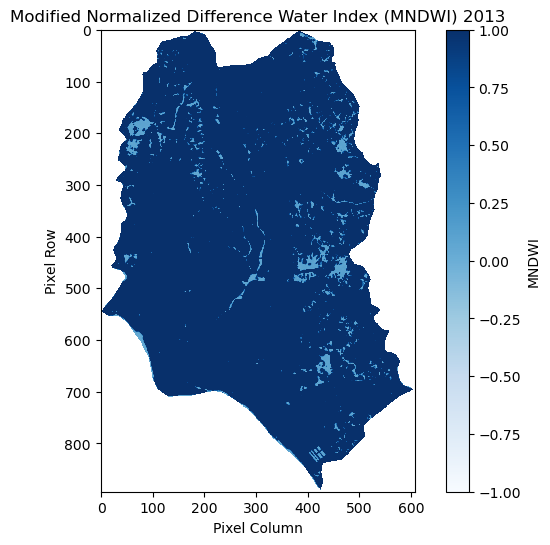

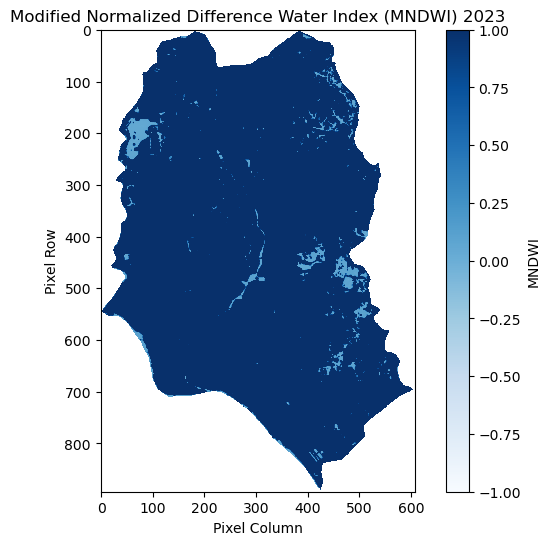

In [4]:
# Paths to data
ROOT = './Landsat8/cropped/'

# MNDWI calculation for 2013
green_band_path_2013 = ROOT + '2013/LC08_L2SP_137044_20131224_20200912_02_T1_SR_B3.TIF'
swir_band_path_2013 = ROOT + '2013/LC08_L2SP_137044_20131224_20200912_02_T1_SR_B6.TIF'
calc_mndwi(green_band_path_2013, swir_band_path_2013, '2013')

# MNDWI calculation for 2023
green_band_path_2023 = ROOT + '2023/LC08_L2SP_137044_20231102_20231109_02_T1_SR_B3.TIF'
swir_band_path_2023 = ROOT + '2023/LC08_L2SP_137044_20231102_20231109_02_T1_SR_B6.TIF'
calc_mndwi(green_band_path_2023, swir_band_path_2023, '2023')

